In [1]:
%%capture
!unzip /content/drive/MyDrive/celeba/img_align_celeba.zip

Epoch 01/30 - Average Loss: 7405.9970


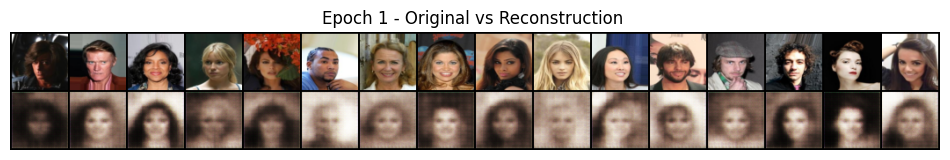

Epoch 02/30 - Average Loss: 6738.0540


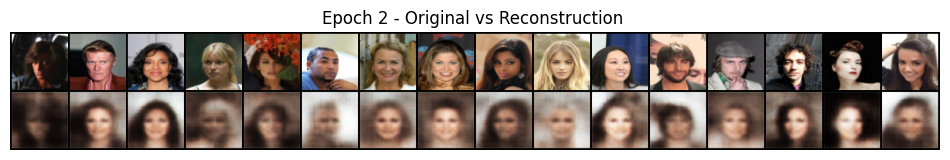

Epoch 03/30 - Average Loss: 6622.0853


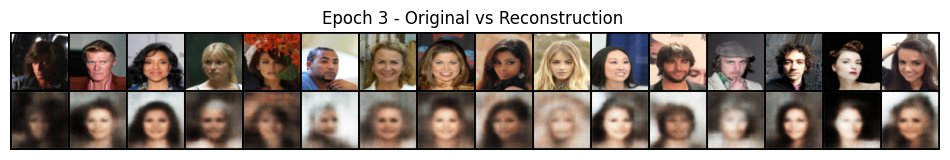

Epoch 04/30 - Average Loss: 6547.8844


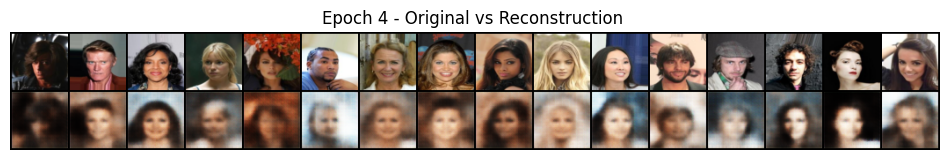

Epoch 05/30 - Average Loss: 6506.5410


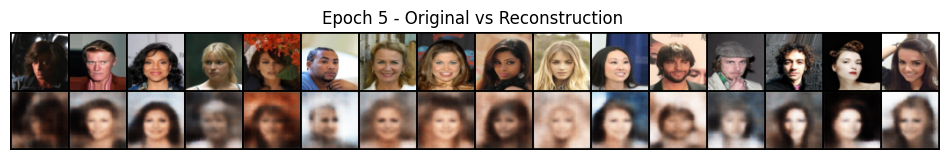

Epoch 06/30 - Average Loss: 6469.6811


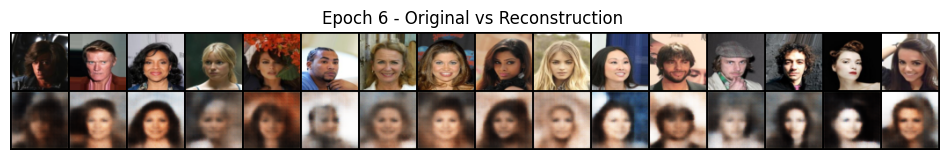

Epoch 07/30 - Average Loss: 6451.8823


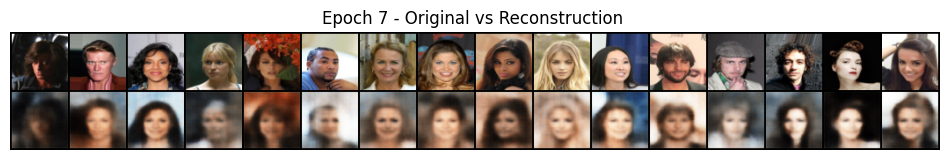

Epoch 08/30 - Average Loss: 6428.4545


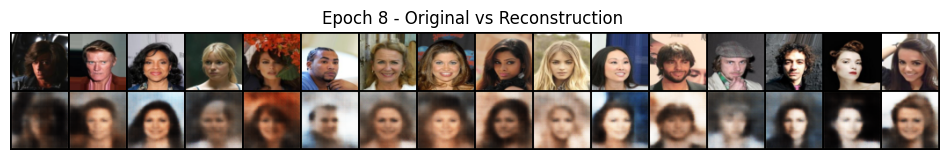

Epoch 09/30 - Average Loss: 6416.4579


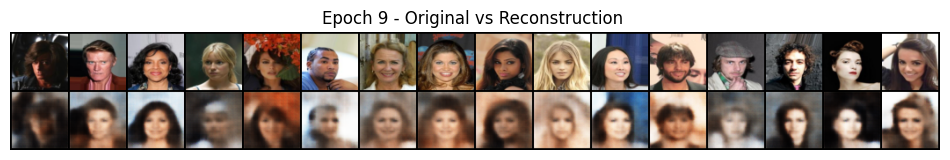

Epoch 10/30 - Average Loss: 6400.2051


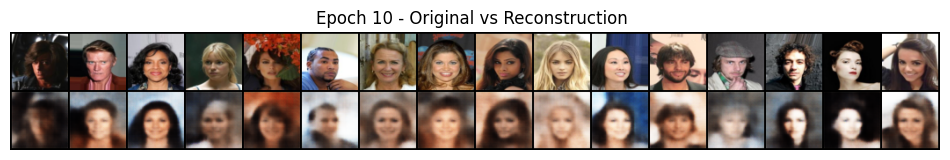

Epoch 11/30 - Average Loss: 6382.2273


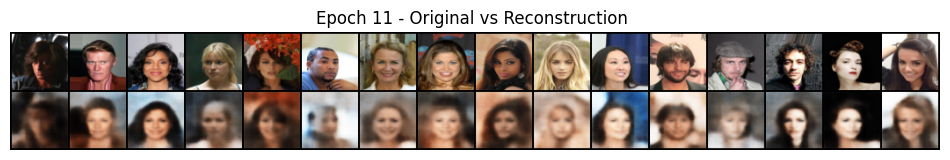

Epoch 12/30 - Average Loss: 6385.6626


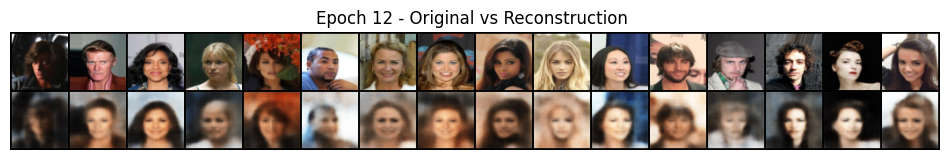

Epoch 13/30 - Average Loss: 6366.7762


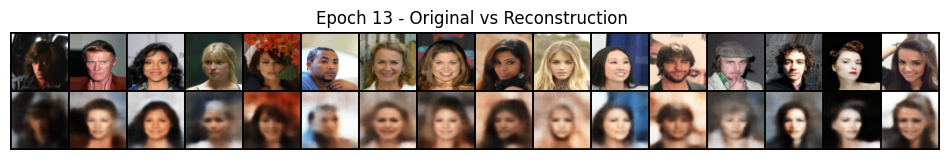

Epoch 14/30 - Average Loss: 6353.4542


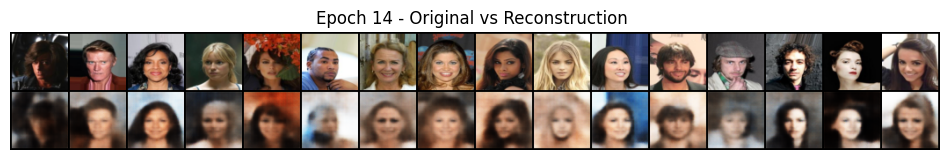

Epoch 15/30 - Average Loss: 6365.6089


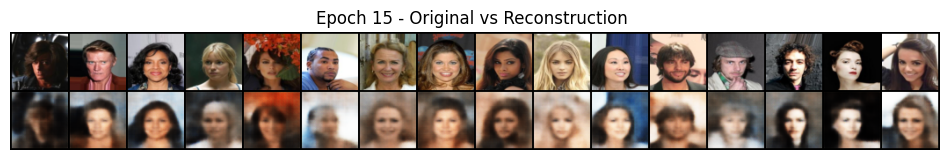

Epoch 16/30 - Average Loss: 6354.5153


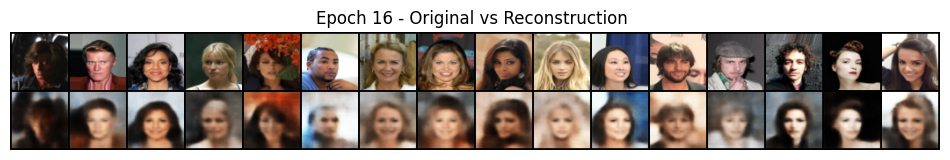

Epoch 17/30 - Average Loss: 6340.3492


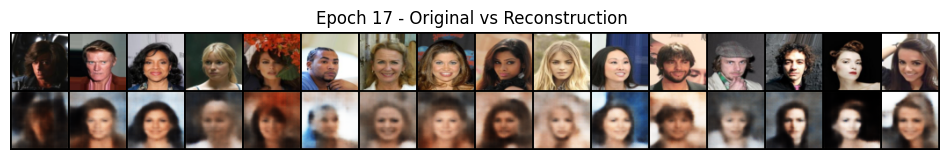

Epoch 18/30 - Average Loss: 6334.4973


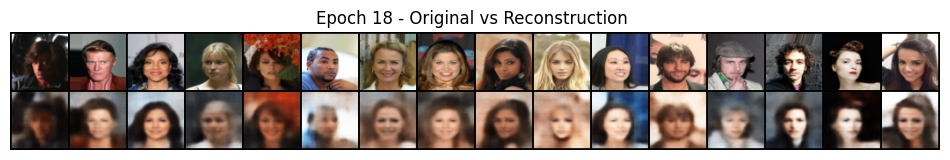

Epoch 19/30 - Average Loss: 6329.5507


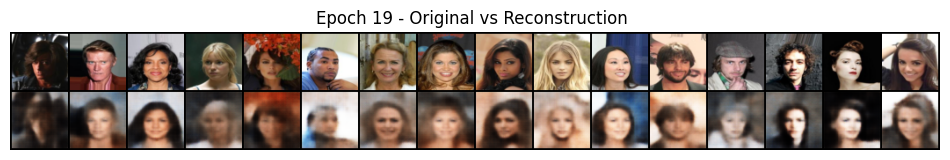

Epoch 20/30 - Average Loss: 6325.0186


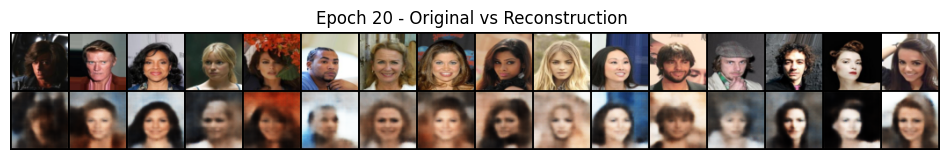

Epoch 21/30 - Average Loss: 6321.9205


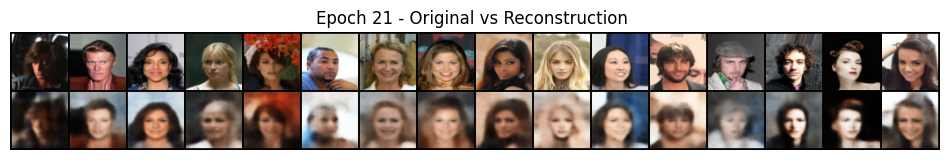

Epoch 22/30 - Average Loss: 6326.0445


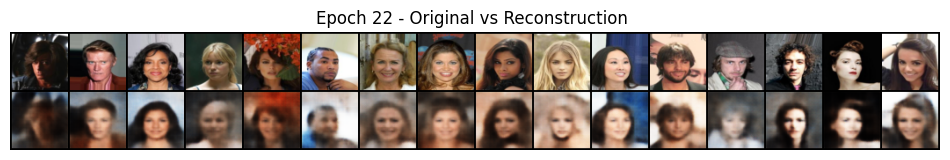

Epoch 23/30 - Average Loss: 6319.8157


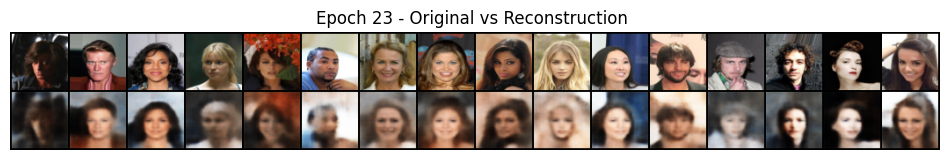

Epoch 24/30 - Average Loss: 6317.6445


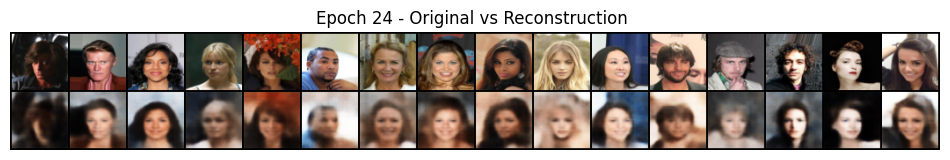

Epoch 25/30 - Average Loss: 6316.7161


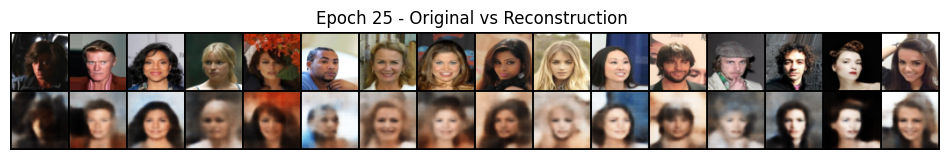

Epoch 26/30 - Average Loss: 6313.8427


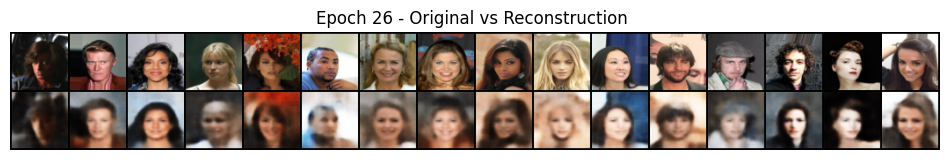

Epoch 27/30 - Average Loss: 6305.8981


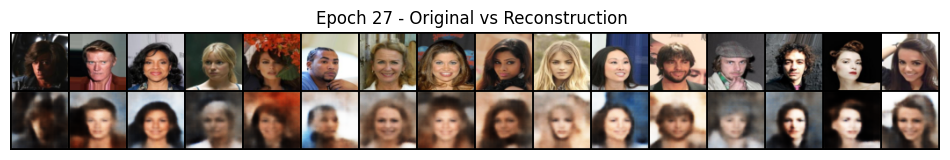

Epoch 28/30 - Average Loss: 6300.4102


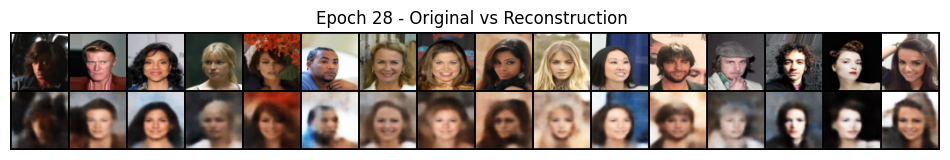

Epoch 29/30 - Average Loss: 6301.9079


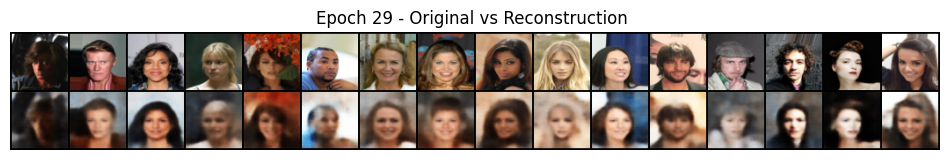

Epoch 30/30 - Average Loss: 6302.8352


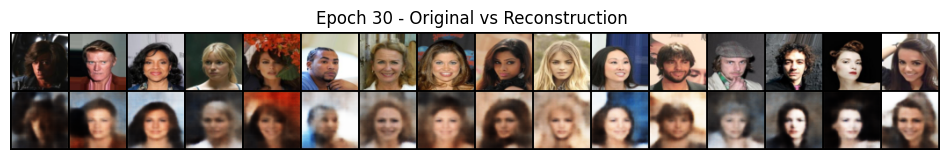

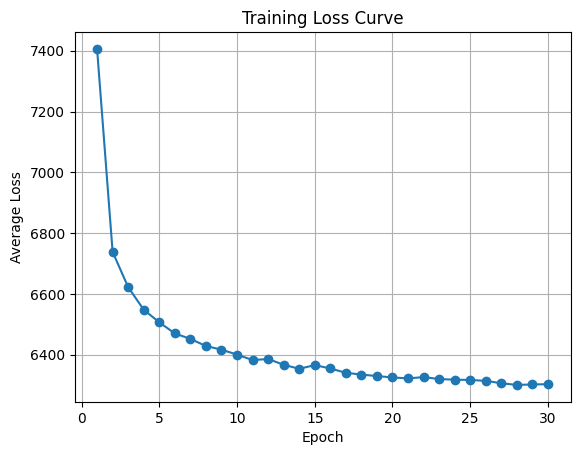

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils as vutils
from PIL import Image
import matplotlib.pyplot as plt

IMAGE_SIZE = 64            # Setting the Image size to 64
LATENT_DIM = 128           # Setting the Latent Dimension of 128 as a part of Initial Experimentation.
BATCH_SIZE = 128
EPOCHS = 30
DATA_DIR = '/content/img_align_celeba'

# Image transformations
img_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.CenterCrop(IMAGE_SIZE),              # Crop the center of the image for consistency
    transforms.ToTensor(),
])

class CelebDataset(Dataset):
    def __init__(self, root_dir, transform=None, max_images=5000):
        self.root_dir = root_dir
        self.transform = transform
        self.files = sorted([
            os.path.join(root_dir, fname)
            for fname in os.listdir(root_dir)
            if fname.lower().endswith(('.png', '.jpg', '.jpeg'))
        ])
        if max_images is not None:
            self.files = self.files[:max_images]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img


def get_data_loader(data_dir, batch_size=BATCH_SIZE, max_images=5000):
    dataset = CelebDataset(root_dir=data_dir, transform=img_transforms, max_images=max_images)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    return loader

# Model Architecture
class ConvVAE(nn.Module):
    def __init__(self, image_size=IMAGE_SIZE, latent_dim=LATENT_DIM, in_channels=3, hidden_dims=None):
        super(ConvVAE, self).__init__()
        self.image_size = image_size
        self.latent_dim = latent_dim


        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256]

        # Building the encoder
        encoder_blocks = []
        channels = in_channels
        for h_dim in hidden_dims:
            encoder_blocks.append(
                nn.Sequential(
                    nn.Conv2d(channels, h_dim, kernel_size=3, stride=2, padding=1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU()
                )
            )
            channels = h_dim
        self.encoder = nn.Sequential(*encoder_blocks)

        # Calculating the spatial dimensions for connecting to the fully connected layer
        num_downsamples = len(hidden_dims)
        self.spatial_dim = image_size // (2 ** num_downsamples)
        self.enc_out_dim = hidden_dims[-1] * (self.spatial_dim ** 2)

        # Fully connected layers to calculate mean (mu) and log-variance (logvar) of the latent distribution.
        self.fc_mu = nn.Linear(self.enc_out_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.enc_out_dim, latent_dim)


        self.decoder_input = nn.Linear(latent_dim, self.enc_out_dim)  # Mapping latent vector to flattened spatial features

        # Building the decoder by reversing the encoder architecture
        hidden_dims_rev = hidden_dims[::-1]
        decoder_blocks = []
        for i in range(len(hidden_dims_rev) - 1):
            decoder_blocks.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims_rev[i],
                                       hidden_dims_rev[i+1],
                                       kernel_size=3,
                                       stride=2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims_rev[i+1]),
                    nn.LeakyReLU()
                )
            )
        self.decoder = nn.Sequential(*decoder_blocks)

        # Final layer to generate the output image
        self.final_layer = nn.Sequential(
            nn.ConvTranspose2d(hidden_dims_rev[-1],
                               hidden_dims_rev[-1],
                               kernel_size=3,
                               stride=2,
                               padding=1,
                               output_padding=1),
            nn.BatchNorm2d(hidden_dims_rev[-1]),
            nn.LeakyReLU(),
            nn.Conv2d(hidden_dims_rev[-1], in_channels, kernel_size=3, padding=1),
            nn.Sigmoid()  # Sigmoid activation for pixel values between 0 and 1
        )

    def encode(self, x):
        enc = self.encoder(x)
        enc_flat = torch.flatten(enc, start_dim=1)  # Flatten the output
        mu = self.fc_mu(enc_flat)  # Compute the mean of the latent distribution
        logvar = self.fc_logvar(enc_flat)  # Compute the log variance of the latent distribution
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)  # Compute the standard deviation
        eps = torch.randn_like(std)  # Sample from a standard normal distribution
        return mu + eps * std  # Reparameterize to allow gradient flow through the stochastic node

    def decode(self, z):
        dec_input = self.decoder_input(z)  # Map latent vector back to the flattened feature space
        dec_input = dec_input.view(z.size(0), -1, self.spatial_dim, self.spatial_dim)  # Reshape to a spatial feature map
        dec = self.decoder(dec_input)
        recon = self.final_layer(dec)  # Generate the final reconstructed image
        return recon

    def forward(self, x):
        mu, logvar = self.encode(x)  # Encode the input to get latent distribution parameters
        z = self.reparameterize(mu, logvar)  # Sample latent vector using the reparameterization trick
        reconstruction = self.decode(z)  # Decode the latent vector to reconstruct the input image
        return reconstruction, mu, logvar

# Define the loss function
def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    recon_loss = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')  # Reconstruction loss using binary cross-entropy
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())  # KL divergence to regularize the latent distribution
    return recon_loss + beta * kld_loss  # Combined loss as in the original paper

# Training and evaluation
def train_vae(model, dataloader, epochs=EPOCHS, lr=1e-3, sample_dir='samples'):
    optimizer = optim.Adam(model.parameters(), lr=lr)  # Adam optimizer
    model.train()

    loss_history = []

    fixed_batch = next(iter(dataloader))[:16].to(device)  #Fixed batch for consistent reconstruction comparison

    for epoch in range(1, epochs + 1):
        total_loss = 0.0
        for batch in dataloader:
            batch = batch.to(device)
            optimizer.zero_grad()
            recon, mu, logvar = model(batch)  # Forward pass obtain reconstruction, mean, and log variance
            loss = vae_loss(recon, batch, mu, logvar)  # Computing the loss
            loss.backward()  # Backpropagate to calculate gradients
            optimizer.step()  # Updating model weights
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader.dataset)
        loss_history.append(avg_loss)
        print(f"Epoch {epoch:02d}/{epochs} - Average Loss: {avg_loss:.4f}")


        with torch.no_grad():
            recon_fixed, _, _ = model(fixed_batch)
            comp = torch.cat([fixed_batch, recon_fixed])
            grid = vutils.make_grid(comp.cpu(), nrow=16)
            plt.figure(figsize=(12, 6))
            plt.imshow(grid.permute(1, 2, 0))
            plt.title(f'Epoch {epoch} - Original vs Reconstruction ')
            plt.axis('off')
            plt.show()


        with torch.no_grad():
            z_sample = torch.randn(64, model.latent_dim).to(device)
            samples = model.decode(z_sample)  # Decode the latent vectors to generate new images



    plt.figure()
    plt.plot(range(1, epochs + 1), loss_history, marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.title('Training Loss Curve')
    plt.grid(True)
    plt.show()


if __name__ == '__main__':
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    loader = get_data_loader(DATA_DIR, batch_size=BATCH_SIZE, max_images=5000)
    vae_model = ConvVAE(image_size=IMAGE_SIZE, latent_dim=LATENT_DIM).to(device)
    train_vae(vae_model, loader, epochs=EPOCHS, lr=1e-3)


## Key findings based on Initial Experimentation
- Leaky relu performs better than relu.
- Batch Normalization improves the result by around 20 percent.
- An image size of 150 or more can result in model capturing features better and avoid potential underfitting.
- A latent dimension in the range of 100-150 works optimally for celeba with an image size of 64.
- Use of liner linear as a starting point for the decoder acts as an initial feature map for better Image reconstructions.
- Use of transposed convolutions in the decoder can be used for upsampling the feature map

# Potential changes to improve the performance
- Increased Image size
- Deeper Convolution Networks
- Attention Mechanisms to focus on relevant part of the image
- Residual Networks with Skip connections to potentially improve convergence
- Dropout to avoid overfitting

